# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

# First project CPT simulations

This is the first Jupyter notebook I made on CPT simulations. 
This code is designed to import and process data from a series of CSV files, as well as extract parameters from corresponding JSON files. The data appears to be related to cone penetration tests (CPT), which are used to determine the mechanical properties of soil.

Here's a step-by-step breakdown of what the code is doing:

* Importing necessary libraries: The code starts by importing various libraries, including pandas for data manipulation, matplotlib for plotting, os for interacting with the operating system, json for parsing JSON files, and math and numpy for mathematical operations.

* Setting up directory paths and file names: The code sets up the root directory path and gets a list of subdirectory names. It also defines the file name for the CSV files and the JSON files.

* Extracting parameters from JSON files: The code loops through each subdirectory, opens the corresponding JSON file, and extracts various parameters. These parameters include:
  * Problem name,Water pressure, Constant vertical stress, Constant horizontal stress, Desired contact friction angle, Cone radius, Initial depth, Velocity, Time step, Distance mesh size (interior and boundary), Characteristic length, Non-local variables
  * These parameters are stored in separate lists.

* Importing and processing CSV files: The code imports the CSV files and stores the data in a dictionary. 
* It then processes the data by:
  * Removing values from previous restarts
  * Modifying the data to get CPT output based on the project parameters
  * Filtering the CPT output based on the variability of qnet (a parameter in the data)
  * Storing processed data: The processed data is stored in a new dictionary, data_int, with the same structure as the original data dictionary.

* Adding filtered data: The code adds two new filtered arrays of qnet to the processed data: one filtered by standard deviation and another smoothed with a moving average.

* Updating the data dictionary: The processed data, including the filtered qnet arrays, is stored in the data_int dictionary.


In [ ]:
import pandas as pd

import os

import json

import math

import numpy as np

# Find the location of OneDrive
one_drive_path = None
for root, dirs, files in os.walk(os.path.expanduser('~')):
    if 'OneDrive' in dirs:
        one_drive_path = os.path.join(root, 'OneDrive')
        break

if one_drive_path is None:
    raise FileNotFoundError("OneDrive not found")

#print(one_drive_path)

# Find the Regularization folder within OneDrive
Tries_on_u2correction_path = None

for root, dirs, files in os.walk(one_drive_path):
    if 'Tries_on_u2correction' in dirs:
        Tries_on_u2correction_path = os.path.join(root, 'Tries_on_u2correction')
        break

if Tries_on_u2correction_path is None:
    raise FileNotFoundError("Tries_on_u2correction folder not found in OneDrive")

#print(Tries_on_u2correction_path)
# Append the rest of the path
root_dir = Tries_on_u2correction_path

print(root_dir)

In [2]:

folder_names = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
#print(folder_names)
file_count = len(folder_names)
print('Model count :'+str(file_count))

csv_files=[]; problem_name_S=[]; water_pressure_S = []; constant_vertical_stress_S = [] ; constant_horizontal_stress_S = [] ; desired_contact_friction_angle_S = [] ; cone_radius_S = [] ; u2_initial_depth_S = [] ; velocity_S = []; time_step_S = []; distance_mesh_size_interior_S = []; distance_mesh_size_boundary_S = []; characteristic_length_S = []; non_local_variables_S = []

for sub_dir in folder_names:
    file_name = 'cone_penetration_data.csv'
    f=root_dir + '/' + sub_dir + '/' + file_name
    csv_files.append(f)                           #-> output string array containing path to csv_files
    
    #Importinfo from JSON file. Code generated through blackbox.ai by simply giving the JSON and asking to extract data :DDD
    # Step 1: Read the JSON file with
    file_name='ProjectParameters.json'
    f=root_dir + '/' + sub_dir + '/' + file_name
    with open(f, 'r') as file:
        Project_par = json.load(file)
    
    # Extract the problem name
    problem_name = Project_par['problem_data']['problem_name']
    print("Problem Name:", problem_name)
    problem_name_S.append(problem_name)
    # Extract the water pressure value
    
    for process in Project_par['constraints_process_list']:
        if process['process_module'] == 'SolidMechanicsApplication.assign_scalar_to_nodes_process':
            if process['Parameters']['variable_name'] == 'WATER_PRESSURE':
                water_pressure = -process['Parameters']['value']
                break
    
    print("Water Pressure:", water_pressure)
    water_pressure_S.append(water_pressure)
    # Extract the constant vertical stress and constant horizontal stress
    
    for process in Project_par['loads_process_list']:
        if process['process_module'] == 'SolidMechanicsApplication.assign_initial_HM_state_process':
            constant_vertical_stress = -process['Parameters']['constant_vertical_stress']
            constant_horizontal_stress = -process['Parameters']['constant_horizontal_stress']
            break
    
    print("Constant Vertical Stress:", constant_vertical_stress)
    print("Constant Horizontal Stress:", constant_horizontal_stress)
    constant_vertical_stress_S.append(constant_vertical_stress);constant_horizontal_stress_S.append(constant_horizontal_stress)
    # Extract the DESIRED_CONTACT_FRICTION_ANGLE
    
    for process in Project_par['problem_process_list']:
        if process['process_module'] == 'ContactMechanicsApplication.parametric_walls_process':
            for parametric_wall in process['Parameters']['parametric_walls']:
                if 'contact_options' in parametric_wall:
                    desired_contact_friction_angle = parametric_wall['contact_options']['friction_properties']['DESIRED_CONTACT_FRICTION_ANGLE']
                    break
            if desired_contact_friction_angle is not None:
                break
    
    print("Desired Contact Friction Angle:", desired_contact_friction_angle)
    desired_contact_friction_angle_S.append(desired_contact_friction_angle)
    # Extract the cone radius, u2 initial depth, and velocity

    for process in Project_par['problem_process_list']:
        if process['process_module'] == 'PfemApplication.cone_penetration_utility':
            cone_radius = process['Parameters']['cone_radius']
            u2_initial_depth = process['Parameters']['u2_initial_depth']
            velocity = process['Parameters']['velocity']
            break
    
    print("Cone Radius:", cone_radius)
    print("U2 Initial Depth:", u2_initial_depth)
    print("Velocity:", velocity)
    cone_radius_S.append(cone_radius);u2_initial_depth_S.append(u2_initial_depth);velocity_S.append(velocity)
    
    # Extract the time step, the refinement of the mesh-size, the characteristic-length and the variables transformed into their non-local value 
    
    time_step = Project_par['time_settings']['time_step']
    print("Time Step:", time_step)
    time_step_S.append(time_step)

    for process in Project_par['problem_process_list']:
        if process['process_module'] == 'MeshersApplication.remesh_domains_process':
            for domain in process['Parameters']['domains']:
                refine_options = domain['Parameters']['refine_options']
                distance_mesh_size_interior = refine_options['interior']['distance_mesh_size']
                distance_mesh_size_boundary = refine_options['boundary']['distance_mesh_size']
                break
    print("Distance Mesh Size (Interior):", distance_mesh_size_interior)
    print("Distance Mesh Size (Boundary):", distance_mesh_size_boundary)
    distance_mesh_size_interior_S.append(distance_mesh_size_interior)
    distance_mesh_size_boundary_S.append(distance_mesh_size_boundary)

    for process in Project_par['problem_process_list']:
        if process['process_module'] == 'ConstitutiveModelsApplication.non_local_plasticity_process':
            characteristic_length = process['Parameters']['characteristic_length']
            non_local_variables = process['Parameters']['non_local_variables']
            break
    print("Characteristic Length:", characteristic_length)
    print("Non-Local Variables:", non_local_variables)
    characteristic_length_S.append(characteristic_length)
    
 
# Create a dictionary to store the data from csv files
data = {}
# Import data from each CSV file
column_names=["z_R", "qnet", "fs", "du2","du1","du3"]
for file in csv_files:    
    df = pd.read_csv(file,names=column_names)
    data[file] = pd.DataFrame(df.values, columns=column_names)

# Modify and store in same variable type
time=[];u1=[];u2=[];qnet=[];fs=[]
count=0
data_int={}
for file, array in data.items():
    header=array.columns
    array=array.values
    time = array[:, 0]
    
    # Remove value from previous restart
    mask=[]
    for i in range(len(time)-1) :
        
        if time[i+1]<=time[i] :
            lim=time[i+1]
            #print(lim)
            j=i
            tmp=[]
            while time[j]>=lim and j>=0 :
                tmp.append(j)
                j=j-1
            tmp = np.array(tmp)
            mask=np.append(mask,tmp)
            mask=mask.astype(int)
            #print(mask)
    array=np.delete(array, mask, axis=0)
    #print(array)
    
    #Modify the data from the csv to get CPT output based on the project parameters
    time=array[:, 0]; qnet = array[:, 1] ; fs = array[:, 2]; du1 = array[:, 4]; du2 = array[:, 3] ; du3 = array[:, 5]# time in [s] Fc, Fs in [kN] 
    Ac=math.pi*cone_radius_S[count]*cone_radius_S[count] ; As=7.5*cone_radius_S[count]*2*math.pi*cone_radius_S[count]  # Ac: Area cone base [m2] As : Area of the sleeve [m2]
    u0=water_pressure_S[count];sv0=constant_vertical_stress_S[count]# stress [kPa]
    z_R=time*velocity_S[count]/cone_radius_S[count];qnet=-qnet/Ac-sv0-u0; fs=-fs/As; du2=du2-u0; du1=du1-u0
    array[:, 0]=z_R ; array[:, 1]=qnet; array[:, 2]=fs; array[:, 3]=du2; array[:, 4]=du1
    
    #Modify the data from the csv to get filtered CPT output based on the variability of qnet
    y_int = np.arange(z_R[0], z_R[-1], 0.002)
    x_int = np.interp(y_int, z_R, qnet)
    x_int = pd.Series(x_int)
    
    k = 55
    M=x_int.rolling(window=k).std()
    
    mask = M >= np.nanmean(x_int) / 25
    #print(mask)
    x_filt = x_int.copy()
    x_filt[mask] = np.nan
    x_filt_mean=x_filt.rolling(window=25).mean()
    x_filt=x_filt.values
    x_filt_mean=x_filt_mean.values
    
    tmp = np.empty((len(y_int), 5))
    for i, _ in enumerate(tmp.T):
        tmp[:,i] = np.interp(y_int, z_R, array[:,i+1])
    array=np.column_stack([y_int, tmp])
    #Append the two new filtered array of qnet 1)std deviation filter 2)smoothed with moving average
    array=np.column_stack([array, x_filt,x_filt_mean])
    #Fill data for each file with modified output
    header=np.append(header,['qnet_filt_dev','qnet_filt_dev_mean'])
    data_int[file]=pd.DataFrame(array, columns=header)
    true_z_R=pd.DataFrame(z_R, columns=['true_z_R'])
    data_int[file]=pd.concat([data_int[file],true_z_R], axis=1)
    #Update of the counter for the project parameters
    count=count+1
    

Model count :17
Problem Name: OCR_1_d_inter_15grad_Ir_basso_modello_ridotto_eta_0p5_new_u2
Water Pressure: 50
Constant Vertical Stress: 32
Constant Horizontal Stress: 13.7
Desired Contact Friction Angle: 15
Cone Radius: 0.01784
U2 Initial Depth: 0.043
Velocity: 0.02
Time Step: 0.001
Distance Mesh Size (Interior): 0.004
Distance Mesh Size (Boundary): 0.008
Characteristic Length: 0.004
Non-Local Variables: ['NONLOCAL_HENCKY_ELASTIC_VOLUMETRIC_STRAIN']
Problem Name: OCR_4_15g_modello_ridotto_eta_0p33_Ksnotmv_new_velocity_new_stab_wP_10
Water Pressure: 30
Constant Vertical Stress: 8
Constant Horizontal Stress: 7.6
Desired Contact Friction Angle: 15
Cone Radius: 0.01784
U2 Initial Depth: 0.0382
Velocity: 0.02
Time Step: 0.01
Distance Mesh Size (Interior): 0.002
Distance Mesh Size (Boundary): 0.004
Characteristic Length: 0.004
Non-Local Variables: ['NONLOCAL_HENCKY_ELASTIC_VOLUMETRIC_STRAIN']
Problem Name: OCR_4_15g_modello_ridotto_eta_0p33_Ksnotmv_new_velocity_new_stab_wP_1p75
Water Pressur

C:\Users\User\AppData\Local\Temp\ipykernel_33080\747010817.py:151: RuntimeWarning: Mean of empty slice
  mask = M >= np.nanmean(x_int) / 25
C:\Users\User\AppData\Local\Temp\ipykernel_33080\747010817.py:151: RuntimeWarning: Mean of empty slice
  mask = M >= np.nanmean(x_int) / 25


In [3]:
import pandas as pd

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Problem Name': problem_name_S,
    'Water Pressure': water_pressure_S,
    'Constant Vertical Stress': constant_vertical_stress_S,
    'Constant Horizontal Stress': constant_horizontal_stress_S,
    'Desired Contact Friction Angle': desired_contact_friction_angle_S,
    'Cone Radius': cone_radius_S,
    'U2 Initial Depth': u2_initial_depth_S,
    'Velocity': velocity_S,
    'Time Step': time_step_S,
    'Distance Mesh Size Interior': distance_mesh_size_interior_S,
    'Distance Mesh Size Boundary': distance_mesh_size_boundary_S,
    'Characteristic Length': characteristic_length_S
})

# Create a DataFrame from the data_int collection
data_int_df = pd.concat(data_int.values(), ignore_index=True)

# Create an Excel writer
with pd.ExcelWriter('summary.xlsx') as writer:
    # Write the summary DataFrame to the first tab
    summary_df.to_excel(writer, sheet_name='Summary', index=False)
    # Write the data_int DataFrame to the second tab
    data_int_df.to_excel(writer, sheet_name='Data', index=False)
    

Problem Name: OCR_1_d_inter_15grad_Ir_basso_modello_ridotto_eta_0p5_new_u2
Water Pressure: 50
Constant Vertical Stress: 32
Constant Horizontal Stress: 13.7
U2 Initial Depth: 0.043


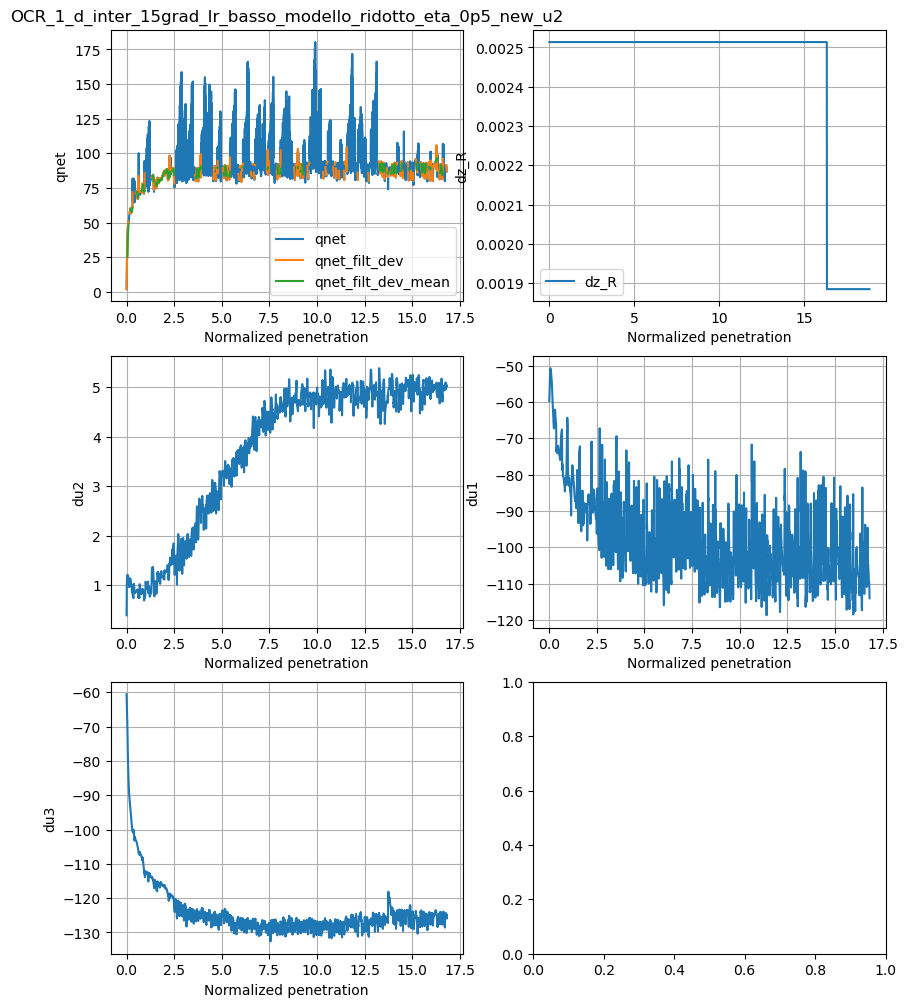

Problem Name: OCR_4_15g_modello_ridotto_eta_0p33_Ksnotmv_new_velocity_new_stab_wP_10
Water Pressure: 30
Constant Vertical Stress: 8
Constant Horizontal Stress: 7.6
U2 Initial Depth: 0.0382


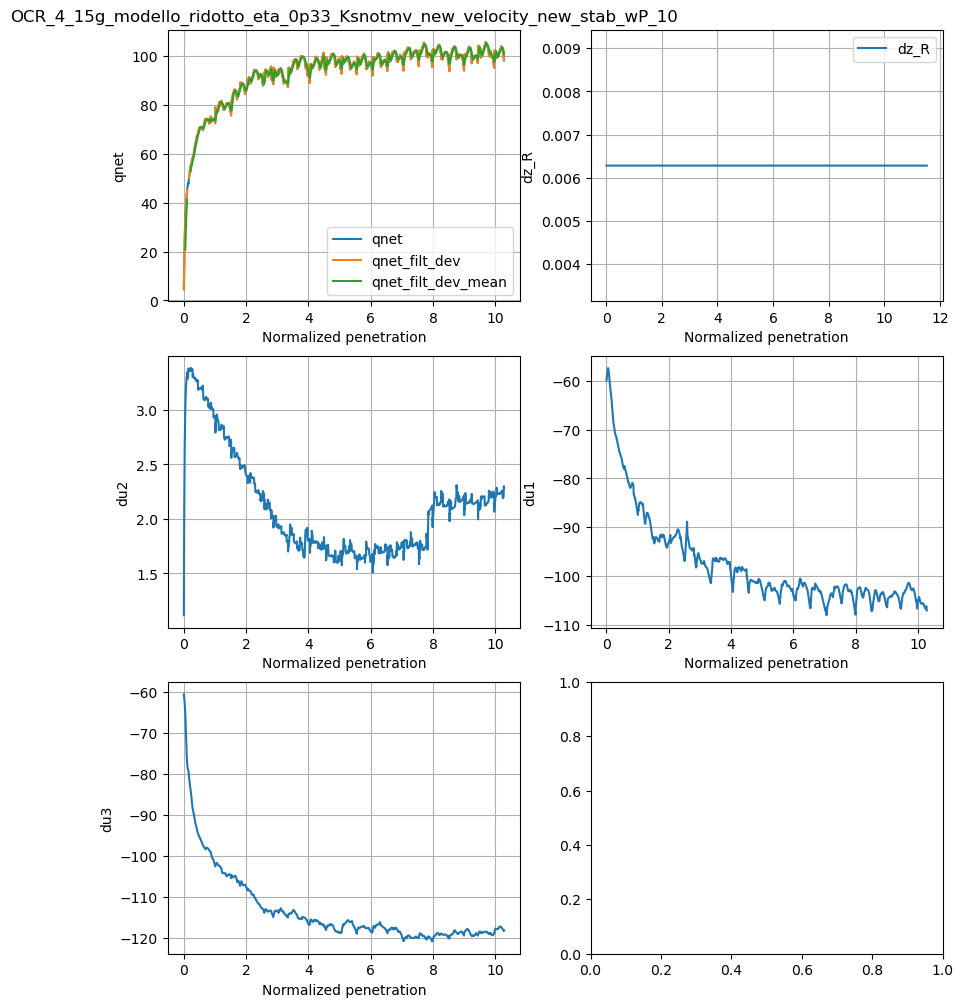

In [4]:
import matplotlib.pyplot as plt

count = 0
plot = 1
print_info = 1

# First subplot

for file, array in data_int.items():
    if array['z_R'].iloc[-1] >= 6:
        fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))
        # axs is a 2D array of axes, with shape (3, 2)
        # You can access each subplot using axs[i, j]
        # For example, axs[0, 0] is the top-left subplot
    
        if print_info:
            print("Problem Name:", problem_name_S[count])
            print("Water Pressure:", water_pressure_S[count])
            print("Constant Vertical Stress:", constant_vertical_stress_S[count])
            print("Constant Horizontal Stress:", constant_horizontal_stress_S[count])
            #print("Desired Contact Friction Angle:", desired_contact_friction_angle_S[count])
            #print("Cone Radius:", cone_radius_S[count])
            print("U2 Initial Depth:", u2_initial_depth_S[count])
            #print("Velocity:", velocity_S[count])
    
        #plot qnet
        axs[0,0].plot(array['z_R'], array['qnet'], label=array.columns[1])
        axs[0,0].plot(array['z_R'], array['qnet_filt_dev'], label=array.columns[6])
        axs[0,0].plot(array['z_R'], array['qnet_filt_dev_mean'], label=array.columns[7])
        axs[0,0].legend()
        axs[0,0].set_title(problem_name_S[count])
        axs[0,0].set_xlabel('Normalized penetration')
        axs[0,0].set_ylabel('qnet')
        axs[0,0].grid()
        
        # get time increments
        arr = (array['true_z_R']) * velocity_S[count] / cone_radius_S[count]
        arr = arr[~np.isnan(arr)]
        diff_arr = np.diff(arr)
        condition = diff_arr <= 0
        diff_arr = diff_arr[~condition]
        arr = arr[1:]
        arr = arr[~condition]
        if np.std(diff_arr) < 10e-6:
            axs[0,1].set_ylim(np.mean(diff_arr) - np.mean(diff_arr) / 2, np.mean(diff_arr) + np.mean(diff_arr) / 2) 
            
        #plot time increments
        axs[0,1].plot(arr, diff_arr, label='dz_R')
        axs[0,1].legend()
        axs[0,1].set_xlabel('Normalized penetration')
        axs[0,1].set_ylabel('dz_R')
        axs[0,1].grid()
        axs[0,1].ticklabel_format(axis='y', style='plain')
        
        #plot fs, du2,du1
        for i, ax in enumerate(axs.flat):
            if i < 2 or i > 4:
                continue
            ax.plot(array['z_R'],array[array.columns[i]],label=array.columns[i])  # plot something on each subplot
            ax.set_xlabel('Normalized penetration')
            ax.set_ylabel(array.columns[i+1])
            ax.grid()
        count = count + 1
        plt.show()